[View in Colaboratory](https://colab.research.google.com/github/agerk/google_ml_crash_course/blob/master/Dog_vs_Cat_MLPractica_Google_Part_1.ipynb)

<h2>Build a Convnet for Cat-vs-Dog Classification from Scratch</h2>

In [0]:
# load liberaries
# deep learning
import tensorflow as tf
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.optimizers import RMSprop
from keras.preprocessing.image import img_to_array, load_img

# data preprocesing
import numpy as np
import random


# forp loting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# for file managment
import os
import zipfile


In [3]:
print(tf.__version__)

1.8.0


<h2> Explore Wxample Data</h2>


In [4]:
# download example data from "Dogs vs. Cats" dataset from Kaggle

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2018-05-30 00:00:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   127MB/s    in 0.5s    

2018-05-30 00:00:11 (127 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# create folder for train and valid
base_dir =  '/tmp/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# create dir fir cat and dog pictures within training dir
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# create dir for cat and dog pictures inside validation dir
validation_cats_dir = os.path.join(valid_dir, 'cats')
validation_dogs_dir = os.path.join(valid_dir, 'dogs')

Check filename in cat and dog training directories 

In [7]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.34.jpg', 'cat.395.jpg', 'cat.616.jpg', 'cat.512.jpg', 'cat.78.jpg', 'cat.760.jpg', 'cat.119.jpg', 'cat.684.jpg', 'cat.782.jpg', 'cat.327.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Find out the total number of cat and dog images in the train and validation dirs

In [8]:
print("total training cat images", len(os.listdir(train_cats_dir)))
print("total training dog images", len(os.listdir(train_dogs_dir)))
print("total validation cat images", len(os.listdir(validation_cats_dir)))
print("total validation dog images", len(os.listdir(validation_dogs_dir)))

total training cat images 1000
total training dog images 1000
total validation cat images 500
total validation dog images 500


For both cats and dogs, we have 1,000 training images and 500 test images

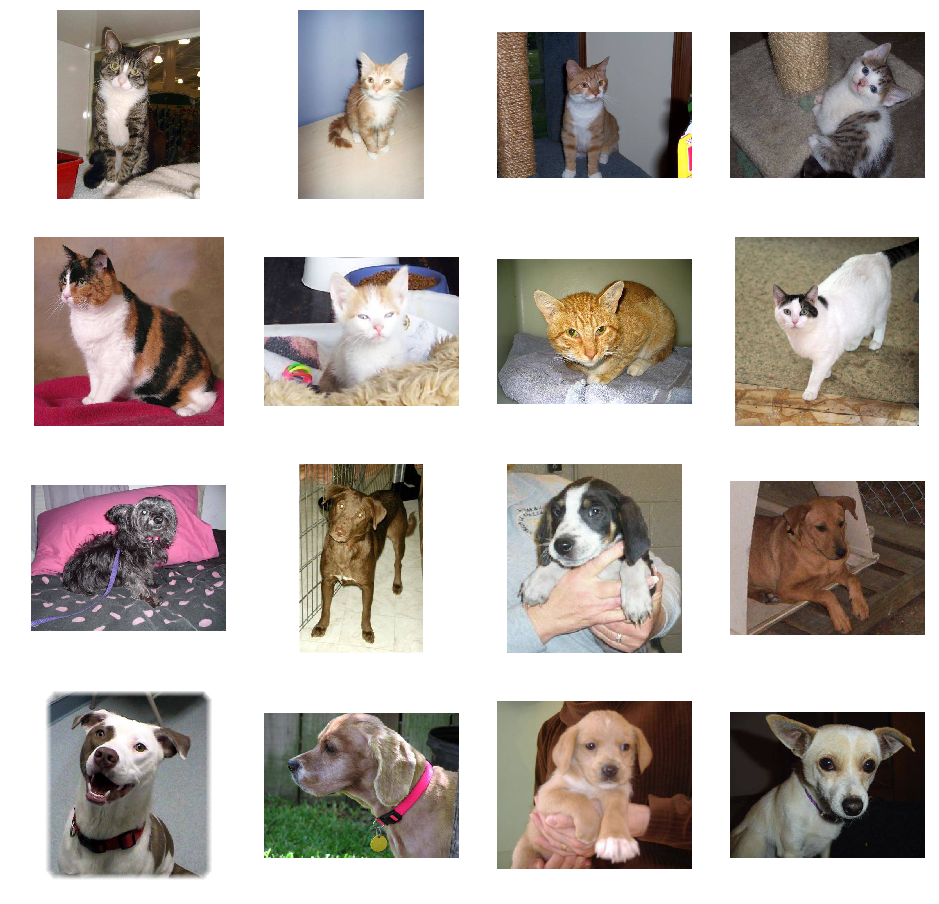

In [9]:
# get sample picture from traning data
# output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0    # index for iterating over images

# display a batch of 8 cat and 8 dog pictures, randomly. 
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                 for fname in train_cat_fnames[pic_index-8:pic_index]]
# print(next_cat_pix)
next_dog_pix = [os.path.join(train_dogs_dir, fname)
               for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  # set up subplot; subplot index starts at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  
  img = mpimg.imread(img_path)
  plt.imshow(img)
  
plt.show()

<h2>Data Preprocessing</h2>

Read and format data for tf/keras
- read data from folder
- convert data to float32 tensors
- feed converted data to the training network
- data will be feed in batch of 20 images of size 150x150 and their binary labels

Data normalization for efficient traning
- for neural network data should be normalized, commonly between [-1, 1] or [0, 1]. For this problem, the raw data [0, 255] will be normalized to [0, 1]

- Use Keras *keras.preprocessing.image.ImageDataGenerator* class using *rescale* parameter

In [32]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale orginally image from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using 
train_generator = train_datagen.flow_from_directory(
    train_dir,    # source directory for training images
    target_size = (150, 150),   # image will be resizzed to 150x150
    batch_size = 20,
    class_mode = 'binary' )

# Flow for validation
validation_generator = test_datagen.flow_from_directory(
    valid_dir, 
    target_size=(150, 150),
    batch_size = 20,
    class_mode = 'binary'
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h2> Building Convnet from scratch</h2>

Architecture: 
-  stack 3 {convolution + relu + maxpooling} modules together
- convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. 
- first convolution extracts 16 filters, the following one extracts 32 filters, and- the last one extracts 64 filters.

In [0]:
# configure the TensorFlow backend session
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))

# imput feature: 150x150x3: 150x150 for width and height of the image pixels, and 3 is color channels (RGB)
img_input = layers.Input(shape=(150, 150, 3))

# Convolution Block 1
# the first conv layer extracts 16 filters that are 3x3
x = layers.Conv2D(16, 3, activation='relu')(img_input)
# conv followed by max-pooling layer with a 2x2 window
x = layers.MaxPooling2D(2)(x)

# Convolution Block 2
# the second conv layer extracts 32 filters that are 3x3
# followed by max-pooling layer with a 2x2 windwow
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

# Convolution Block 3
# the third conv extracts 64 filters that are 3x3 
# followef by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

# Final block-- FC
# First flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)
# create FC layer with ReLu activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)
# create output layer with single node and sigmoid activation function
output = layers.Dense(1, activation='sigmoid')(x)


<h3>Create a model </h3>


In [0]:
# input = input feature map
# output = input feature map + stacked convolution/max-pooling layers + fully connected layer + sigmoid output layer
model = Model(img_input, output)


In [18]:
# summerize model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 64)        0         
__________

<h3> Configure model for traning</h3>

In [0]:
# configure model specification for traninig.
model.compile(loss='binary_crossentropy',
             optimizer = RMSprop(lr=0.001),
             metrics=['acc'])

In [33]:
# train on all 200o images for 15 epochs and validation on 1000 test images
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,   # 2000 images = batch_size(20) * steps(100)
      epochs=15,
      validation_data = validation_generator,
      validation_steps=50,
      verbose=2
    
)

Epoch 1/15
 - 11s - loss: 0.7809 - acc: 0.5450 - val_loss: 0.6492 - val_acc: 0.6750
Epoch 2/15
 - 10s - loss: 0.6545 - acc: 0.6290 - val_loss: 0.6913 - val_acc: 0.5930
Epoch 3/15
 - 10s - loss: 0.5642 - acc: 0.7125 - val_loss: 0.5839 - val_acc: 0.6750
Epoch 4/15
 - 10s - loss: 0.4908 - acc: 0.7625 - val_loss: 0.5904 - val_acc: 0.6930
Epoch 5/15
 - 10s - loss: 0.4003 - acc: 0.8230 - val_loss: 0.6161 - val_acc: 0.7160
Epoch 6/15
 - 10s - loss: 0.3275 - acc: 0.8580 - val_loss: 0.6431 - val_acc: 0.7150
Epoch 7/15
 - 10s - loss: 0.2486 - acc: 0.9005 - val_loss: 0.7096 - val_acc: 0.7320
Epoch 8/15
 - 10s - loss: 0.1811 - acc: 0.9300 - val_loss: 0.8869 - val_acc: 0.6860
Epoch 9/15
 - 10s - loss: 0.1142 - acc: 0.9605 - val_loss: 1.2282 - val_acc: 0.6910
Epoch 10/15
 - 10s - loss: 0.1044 - acc: 0.9720 - val_loss: 1.1202 - val_acc: 0.7270
Epoch 11/15
 - 10s - loss: 0.0666 - acc: 0.9810 - val_loss: 1.2123 - val_acc: 0.7240
Epoch 12/15
 - 10s - loss: 0.0586 - acc: 0.9780 - val_loss: 1.3006 - val_a

<h2>Visualizing Intermediate Representations</h2>

Convnet (or a deep network in general) can be though as an information distillation pipeline.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


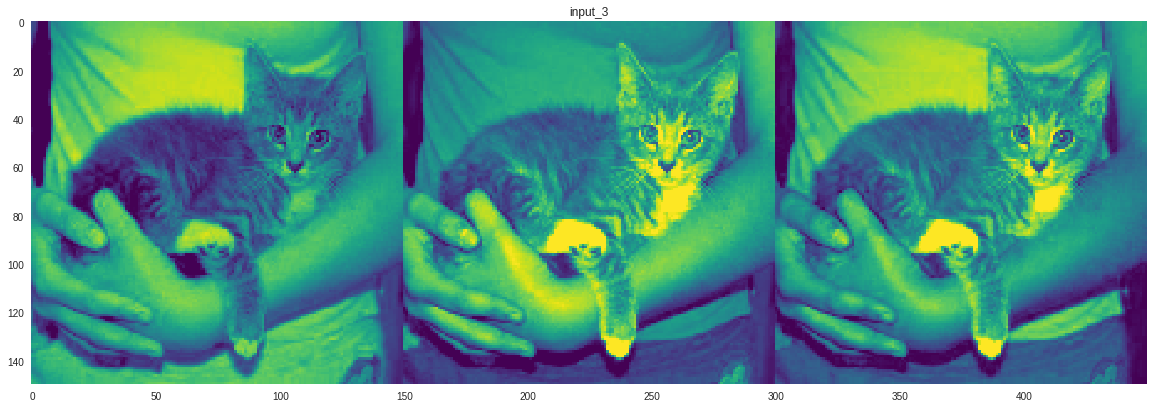

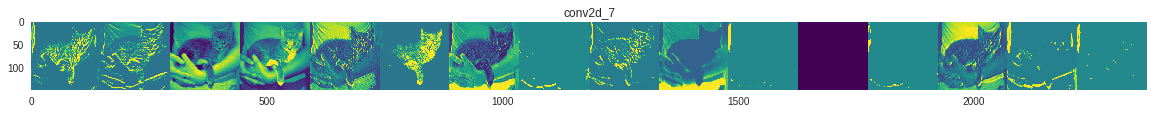

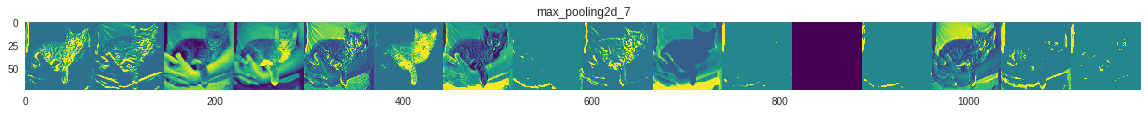

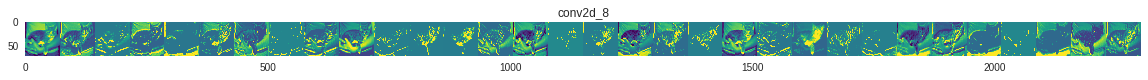

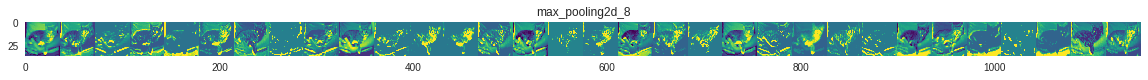

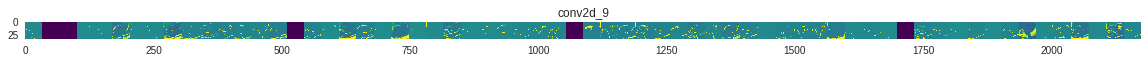

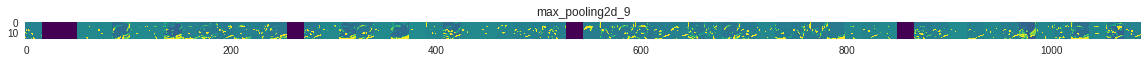

In [45]:
# Define a new Model that will take an image and will output
# intermediate representations for all layers in the previous trained model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))    # PIL image
x = img_to_array(img)   # Numpy array with shape (3, 150, 150)
x = x.reshape((1, ) + x.shape)    # Numpy array with shape (1, 3, 150, 150)

# Rescale by 1/25
x /= 255

# Run image through the network and get all intermdeiate representations for this image
successive_feature_maps = visualization_model.predict(x)

# Name of layers
layer_name = [layer.name for layer in model.layers]

# Display intermediate represenation 
for layer_name, feature_map in zip(layer_name, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do only for the Conv/Maxpool layer, not for FC
    n_features = feature_map.shape[-1]   # num of features in feature map
    # The feature map has shape (1, size, size, n_feautres)
    size = feature_map.shape[1]
    # Title images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. /n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

<h3> Evaluating Accuracy and Loss for the Model</h3>
  
  Plot training/validation accuracy and loss 

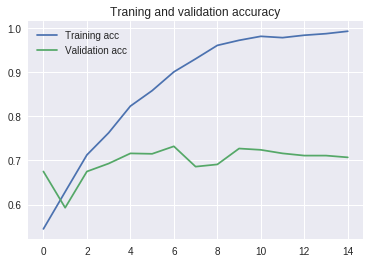

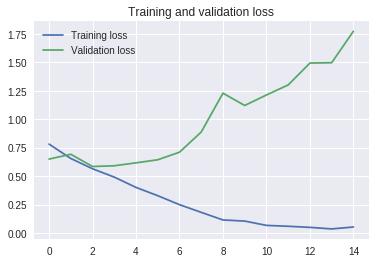

In [56]:
# Retrieve a list of accuracy results on training and test datafor each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve list of results on training and test data setfor each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# plot trainig and validation accuracy per epoch
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Traning and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Cocnclusion: The base model overfit and the next tutorial will fine tune the model to mitigate overfitting.

*This notebook is based on the Google's Machine Learning Practica tutorial*